In [1]:
import os
import time

from efficientnet_pytorch import EfficientNet
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torchvision import datasets, transforms

In [2]:
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = 224
model_path = './models/efficientnet-b3_epoch100.pth'

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

model_test = EfficientNet.from_pretrained('efficientnet-b3')
num_ftrs = model_test._fc.in_features

model_test._fc  = nn.Linear(num_ftrs, len(class_names))

model_test.to(device)

model_test.load_state_dict(torch.load(model_path))
model_test.eval()
print()

Loaded pretrained weights for efficientnet-b3



In [4]:
def inference_model(model, input_image_path):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        with Image.open(input_image_path) as input_image:
            resized_image = data_transforms['val'](input_image).unsqueeze(0).to(device)
            label = input_image_path.split('_')[-1].split('.')[0]
            
            output = model(resized_image)
            _, pred = torch.max(output, 1)
            
        model.train(mode=was_training)
    
    return class_names[pred[0]], label

Image 1
Predict: 團, Label: 田, Time elapsed: 0.5725326538085938



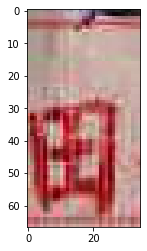

Image 2
Predict: 佳, Label: 佳, Time elapsed: 0.023966073989868164



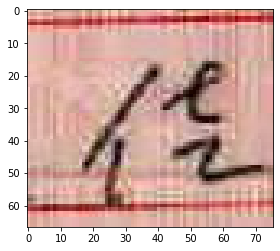

Image 3
Predict: 科, Label: 科, Time elapsed: 0.02293539047241211



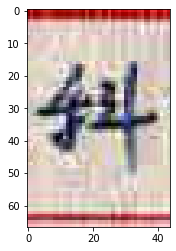

Image 4
Predict: 王, Label: 王, Time elapsed: 0.02278923988342285



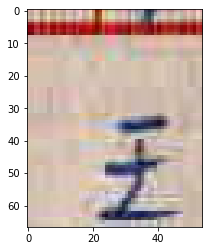

Image 5
Predict: 允, Label: 允, Time elapsed: 0.021093130111694336



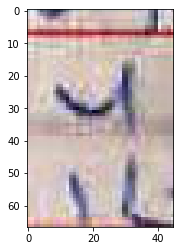

Inference time of one image: 0.22421398162841796


In [5]:
fig = plt.figure()

since = time.time()

words = ['2530_田.jpg', '4531_佳.jpg', '62947_科.jpg', '9997_王.jpg', '54240_允.jpg']

for i, word in enumerate(words):
    start = time.time()
    pred, label = inference_model(model_test, os.path.join('./data/clean/', word))
    print(f'Image {i + 1}\nPredict: {pred}, Label: {label}, Time elapsed: {time.time() - start}\n')
    img = mpimg.imread(os.path.join('./data/clean', word))
    plt.imshow(img)
    plt.show()
    
time_elapsed = time.time() - since

print(f'Inference time of one image: {time_elapsed / len(words)}')

In [6]:
val_dir = './data/val/isnull'
val_words_file = []

for root, dirs, files in os.walk(val_dir, topdown=True):
    for name in files:
        val_words_file.append(name)

preds = []
labels = []

for i, word in enumerate(val_words_file):
    pred, label = inference_model(model_test, os.path.join('./data/clean/', word))
    preds.append(pred)
    labels.append('isnull')

print(f'The accuracy of isnull is {accuracy_score(preds, labels)}')

The accuracy of isnull is 0.06315789473684211


In [7]:
val_dir = './data/val'
val_words = ['仙', '圖', '迅', '鑽', '勁', '班', '央', '衣', '買', '首', '匠', '厚']
val_words_file = []

for val_word in val_words:
    for root, dirs, files in os.walk(os.path.join(val_dir, val_word), topdown=True):
        for name in files:
            val_words_file.append(name)

preds = []
labels = []

for i, word in enumerate(val_words_file):
    pred, label = inference_model(model_test, os.path.join('./data/clean/', word))
    preds.append(pred)
    labels.append(label)
    
print(f'The accuracy of little data images is {accuracy_score(preds, labels)}')

The accuracy of little data images is 0.8235294117647058


In [8]:
pre_labels = []
pre_preds = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_test(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            if not class_names[labels[j]] == 'isnull':
                pre_labels.append(class_names[labels[j]])
                pre_preds.append(class_names[preds[j]])

In [9]:
from sklearn.metrics import classification_report

In [10]:
print(classification_report(pre_labels, pre_preds, labels=class_names[1:] + ['isnull']))

              precision    recall  f1-score   support

           丁       0.90      1.00      0.95        18
           三       1.00      1.00      1.00        21
           上       0.88      0.88      0.88         8
           不       1.00      1.00      1.00        13
           世       0.94      0.94      0.94        17
           丞       1.00      0.92      0.96        12
           中       0.91      1.00      0.95        21
           主       1.00      1.00      1.00         7
           久       0.95      0.95      0.95        19
           之       0.94      1.00      0.97        17
           事       0.94      1.00      0.97        17
           于       0.91      0.83      0.87        12
           五       1.00      0.93      0.97        15
           亞       0.95      1.00      0.98        20
           交       0.91      0.91      0.91        22
           亨       0.88      0.88      0.88         8
           京       1.00      1.00      1.00        20
           亮       0.95    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
